# Figure - Estimate M PCA

May 15, 2022

This notebook was created after a long meeting with James on Sunday May 15

Method 1 (maybe illustrate with schematic) for estimating M_hat: PCA + Regression. 
1. Pretrain RNN with Wfb=M and Wbmi0 and corr(M, Wbmi0^T) = 0.9.
2. Do PCA on the trained RNN, keeping the top 10 PCs.
3. Use regression to relate h to y. The PCs and regression coefficients define Mhat.


In [82]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-2022-4-29'

In [1]:
folder = 'figures-2022-5-15/'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator,FixedFormatter
import matplotlib.pylab as pylab

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import interpolate # don't import stats
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy
import pickle

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [3]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars
from algorithms.weight_mirror import WeightMirror

from utils.plotting import plot_trained_trajectories, paper_format
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


In [4]:
trial_duration = 20
n_in=4
frac_on = 0.4

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

6it [00:00, 56.09it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.2
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fd9b1ef8288>
M norm: 0.84	 M angle: 0.89, 123 iterations

5000it [00:55, 89.37it/s]


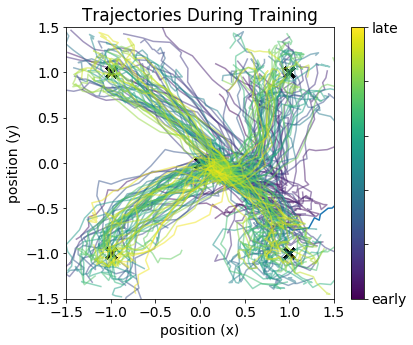

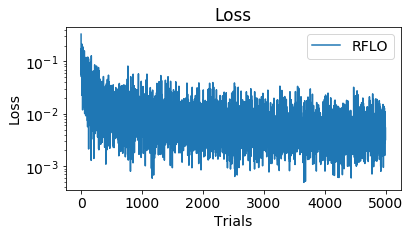

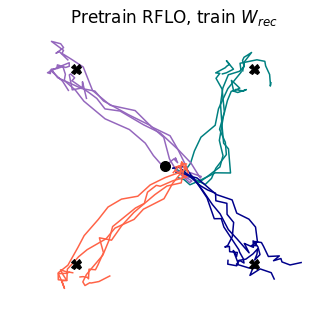

In [5]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,eta_fb=0.1,g_fb=2,
               sig_in=0.0,sig_rec=0.2,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)

w_m = choose_aligned_matrix(net0.w_out.T,n_change=10,overlap=0.9,rng=np.random.RandomState(56),zero=False,tolerance=0.01,loop=1000)

net0.set_weights(w_m = w_m, w_fb = w_m)
rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')



In [6]:
# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_out,net0.w_fb.T)

print('\nw_out0 norm: {:.2f}'.format(norm) + '\t w_out0 vs. w_fb angle: {:.2f}'.format(angle),end='')


w_out0 norm: 0.84	 w_out0 vs. w_fb angle: 0.89

In [ ]:
""" Estimate M_hat """



In [9]:
""" Apply PCA to static activity, Estimate Mhat """
net0_post = RNN(params)
net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
sim0_post = Simulation(net0_post)
trackvars = TrackVars(net0_post,apply_to=[]) 
sim0_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

# concatenate data
activity = sim0_post.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0_post.session_probes['h'])):
    activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)



pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_

print('C: ',pca.components_.shape)
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()

""" Test that transformation is correct with sklearn"""
activity_lowD_pca = pca.transform(activity)

activity_lowD_test = C @ (activity.T - np.repeat(np.expand_dims(pca.mean_,1),activity.shape[0],axis=1))

print(np.sum(activity_lowD_pca - activity_lowD_test.T)) #test


""" Compare with cursor location """
pos = sim0_post.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0_post.session_probes['pos'])):
    pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

500it [00:04, 101.96it/s]


(20, 50)
n_samples,n_features:  (10000, 50)


100it [00:01, 67.68it/s]


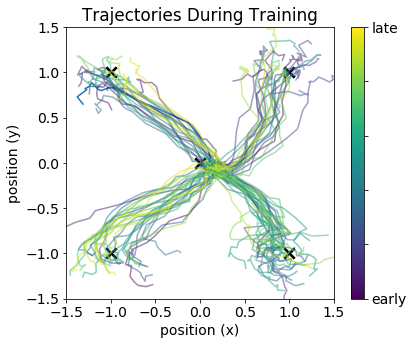

In [11]:
""" Test new decoder """

net1 = RNN(params)


if net0.w_fb.any():
    net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec),w_fb=np.copy(net0.w_fb))
else:
    net1.set_weights(w_in=np.copy(net0.w_in),w_rec=np.copy(net0.w_rec))

net1.set_weights(w_out=D@C) # set w_out and w_m

# initialize simulation, no learning here
sim1 = Simulation(net1)
# rflo1 = RFLO(net1,apply_to=['w_rec']) 
# sim1.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[rflo1], probe_types=['h','y_out','pos'], plot=True, plot_freq=10,train=True)
sim1.run_session(n_trials=100, tasks=[task1,task2,task3,task4], learn_alg=[], probe_types=['h','y_out','pos'], plot=True, plot_freq=1,train=False)



w_m norm: 1.19	 w_m vs. D@C angle: 0.78
D@C norm: 1.15	 w_out0 vs. D@C angle: 0.72

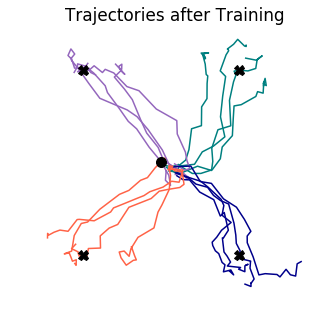

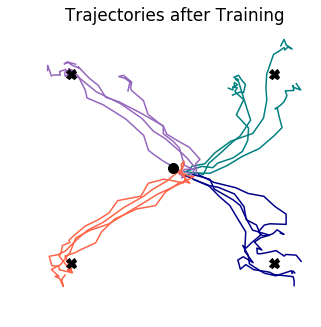

In [15]:
fig = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4])

fig = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4])


# confirm overlap between w_out1 and w_out
norm, angle = return_norm_and_angle(net0.w_m,net1.w_out.T)
print('\nw_m norm: {:.2f}'.format(norm) + '\t w_m vs. D@C angle: {:.2f}'.format(angle),end='')

norm, angle = return_norm_and_angle(net0.w_out,net1.w_out)
print('\nD@C norm: {:.2f}'.format(norm) + '\t w_out0 vs. D@C angle: {:.2f}'.format(angle),end='')

M norm: 0.00	 M angle: 1.00, 0 iterations

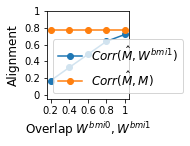

In [47]:
""" Vary Alignment between Wbmi0 and Wbmi1 """
paper = True
save = True


seeds = [1,2,3]
overlaps = [0.2,.4,0.6,0.8,1]
n_changes = [80,60,40,20,0]

corr_dict = {}
corr_dict['angle1'] = []
corr_dict['angle2'] = []

for seed in seeds:
    angle1_list = []
    angle2_list = []
    
    for n_change, overlap in zip(n_changes,overlaps):
        w_out1 = choose_aligned_matrix(net0.w_out,n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.1,loop=1000)
        
        norm, angle = return_norm_and_angle(D@C,w_out1)
        #print('\nw_out0 norm: {:.2f}'.format(norm) + '\t w_out0 vs. w_out1 angle: {:.2f}'.format(angle),end='')
        angle1_list.append(angle)
        
        norm, angle = return_norm_and_angle(net0.w_m,(D@C).T)
        #print('\nw_m norm: {:.2f}'.format(norm) + '\t w_m vs. D@C angle: {:.2f}'.format(angle),end='')
        angle2_list.append(angle)
        
    corr_dict['angle1'].append(angle1_list)
    corr_dict['angle2'].append(angle2_list)

    
fig,ax=plt.subplots()
mn1 = np.mean(np.asarray(corr_dict['angle1']),axis=0)
mn2 = np.mean(np.asarray(corr_dict['angle2']),axis=0)
std1 = np.std(np.asarray(corr_dict['angle1']),axis=0)
std2 = np.std(np.asarray(corr_dict['angle2']),axis=0)
plt.plot(overlaps,mn1,'o-',label=r'$Corr(\hat{M},W^{bmi1})$')
plt.fill_between(overlap,mn1-std1,mn1+std1,alpha=0.5)
plt.plot(overlaps,mn2,'o-',label=r'$Corr(\hat{M},M)$')
plt.fill_between(overlap,mn2-std2,mn2+std2,alpha=0.5)
plt.xlabel('Overlap '+r'$W^{bmi0},W^{bmi1}$')
plt.ylabel('Alignment')
plt.ylim([0,1])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=[0.2,0.4,0.6,0.8,1],ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,1],figsize=(2.25,2.25))

plt.show()

if save:
    fig.savefig(folder+'PCA-estimate-Mhat.pdf')

5it [00:00, 47.40it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.2
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fd9b3d63798>
M norm: 1.15	 M angle: 0.81, 25 iterations

5000it [00:58, 93.49it/s]
500it [00:04, 118.90it/s]


(20, 50)
n_samples,n_features:  (10000, 50)
C:  (10, 50)


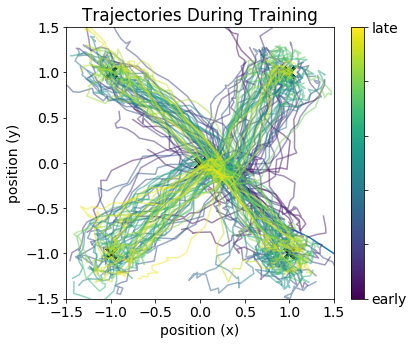

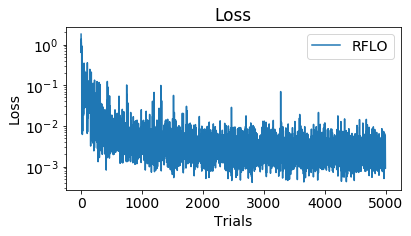

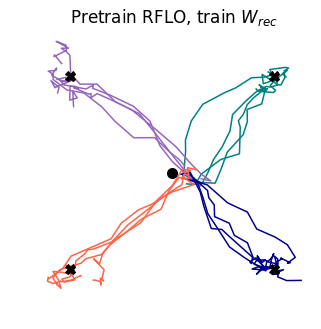

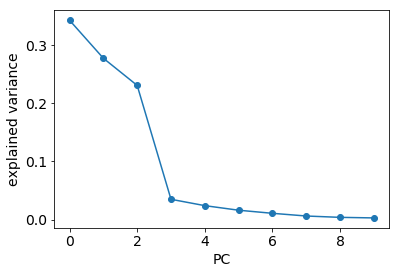

11it [00:00, 105.89it/s]

(20, 2)
(10000, 2)
(2, 10)
M norm: 1.75	 M angle: 0.21, 34 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.21
w_m norm: 2.03	 w_out1 vs. w_m angle: 0.16
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.40	 w_out1 vs. Mhat angle: 0.10

500it [00:04, 118.98it/s]
1500it [00:16, 92.02it/s]
500it [00:04, 118.28it/s]


AR early fit 0.979, late fit 0.992


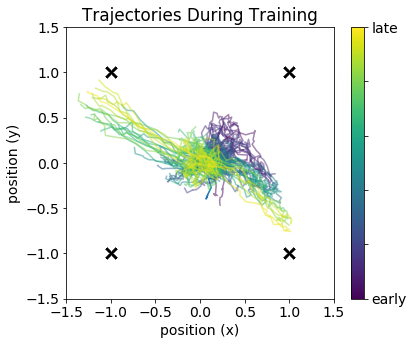

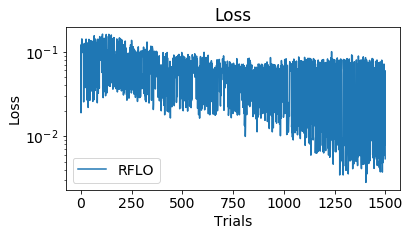

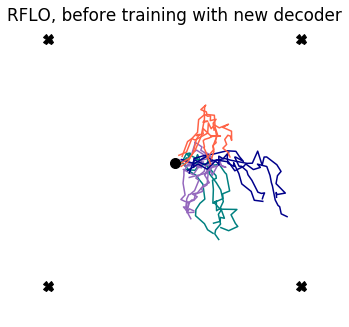

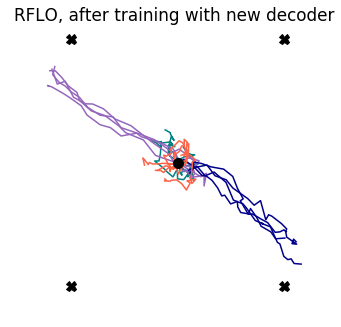

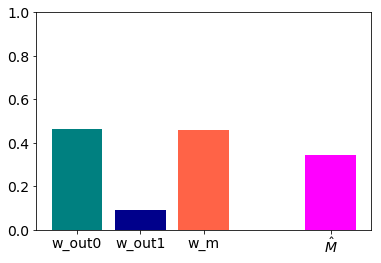

8it [00:00, 79.24it/s]

M norm: 1.60	 M angle: 0.41, 98 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.91	 w_out1 vs. w_m angle: 0.33
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.33	 w_out1 vs. Mhat angle: 0.32

500it [00:04, 118.71it/s]
1500it [00:20, 74.56it/s]
500it [00:04, 114.50it/s]


AR early fit 0.980, late fit 0.991


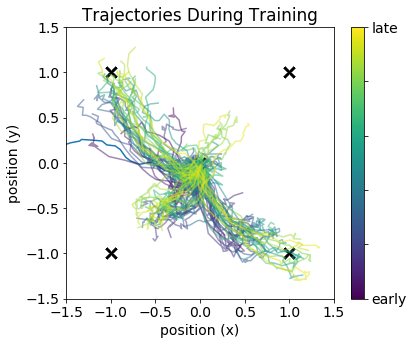

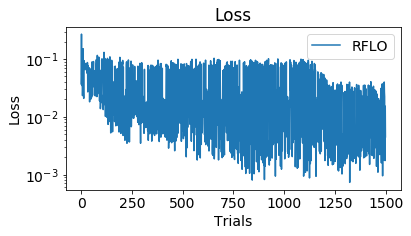

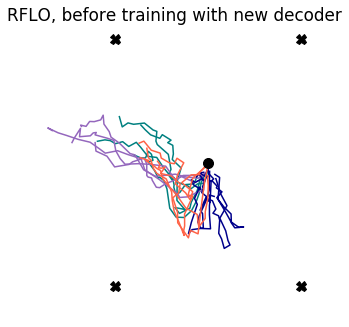

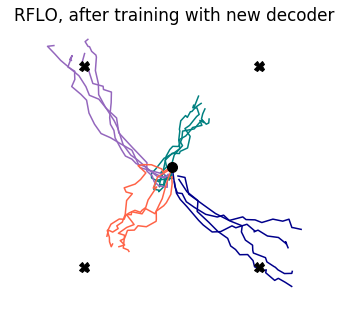

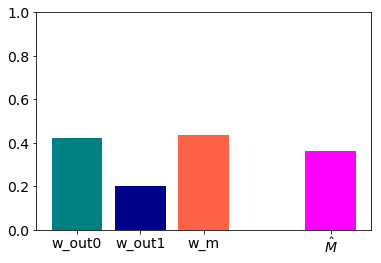

8it [00:00, 62.80it/s]

M norm: 1.37	 M angle: 0.60, 6 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.43
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.27	 w_out1 vs. Mhat angle: 0.44

500it [00:09, 52.44it/s]
1500it [00:26, 57.49it/s]
500it [00:04, 103.09it/s]


AR early fit 0.980, late fit 0.988


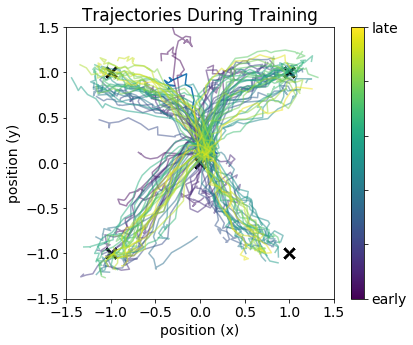

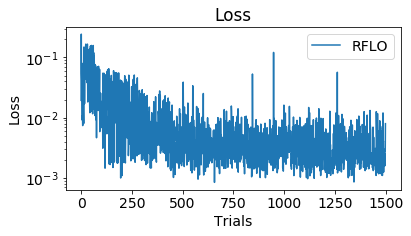

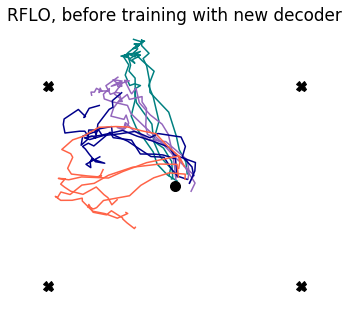

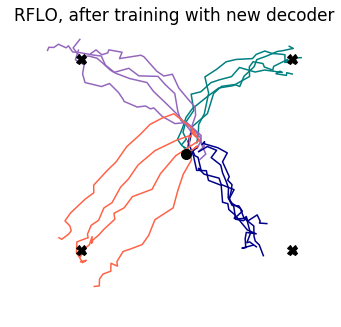

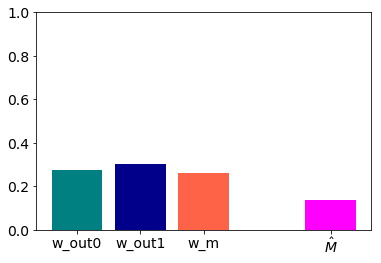

8it [00:00, 75.51it/s]

M norm: 1.00	 M angle: 0.81, 619 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.51	 w_out1 vs. w_m angle: 0.64
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.37	 w_out1 vs. Mhat angle: 0.49

500it [00:04, 107.91it/s]
1500it [00:17, 87.15it/s]
500it [00:04, 110.90it/s]


AR early fit 0.982, late fit 0.986


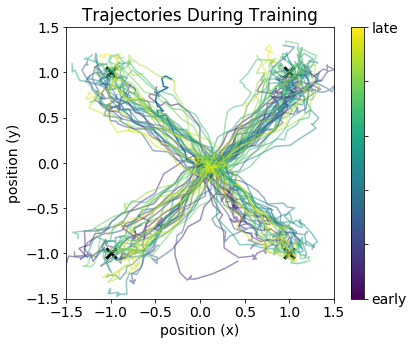

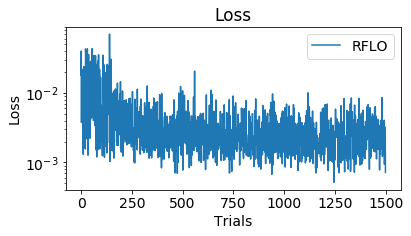

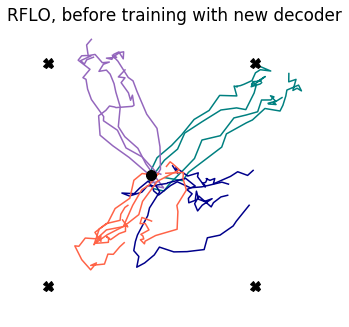

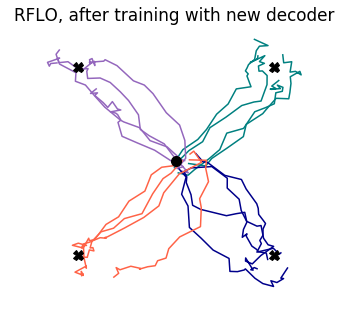

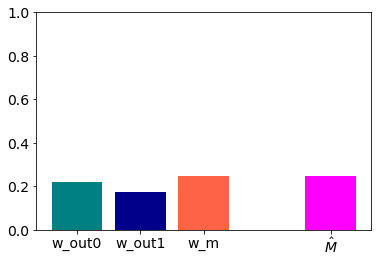

9it [00:00, 87.11it/s]

M norm: 1.75	 M angle: 0.20, 25 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.05	 w_out1 vs. w_m angle: 0.12
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.37	 w_out1 vs. Mhat angle: 0.12

500it [00:04, 106.57it/s]
1500it [00:17, 87.05it/s]
500it [00:06, 80.03it/s]


AR early fit 0.979, late fit 0.990


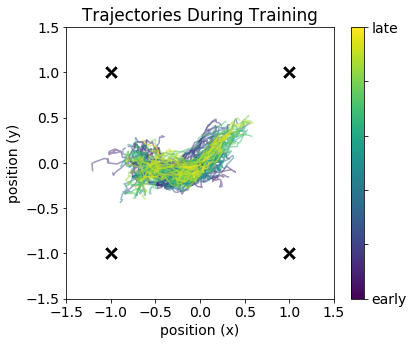

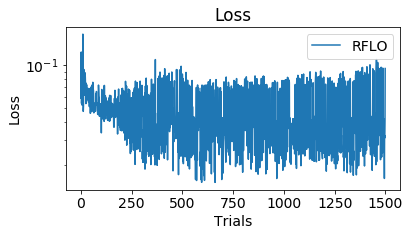

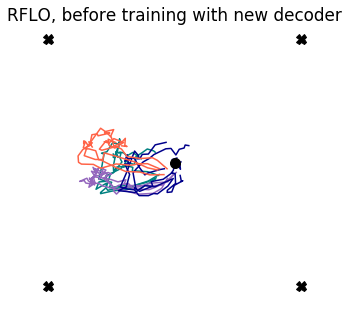

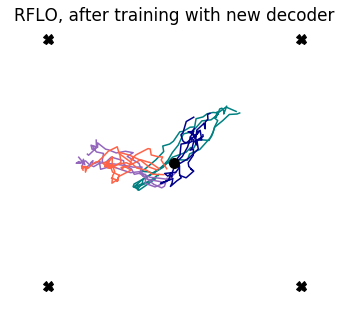

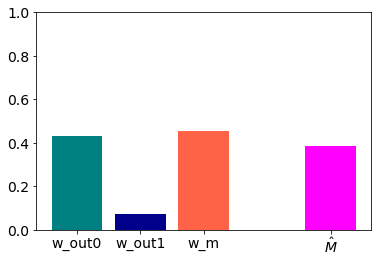

8it [00:00, 77.20it/s]

M norm: 1.61	 M angle: 0.39, 116 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.89	 w_out1 vs. w_m angle: 0.34
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.39	 w_out1 vs. Mhat angle: 0.25

500it [00:04, 108.72it/s]
1500it [00:17, 87.10it/s]
500it [00:04, 116.74it/s]


AR early fit 0.980, late fit 0.991


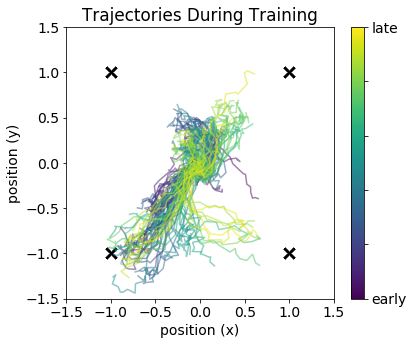

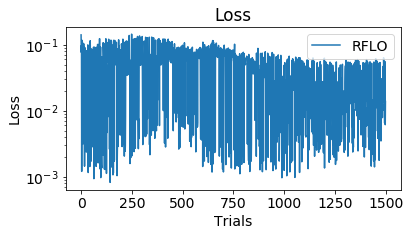

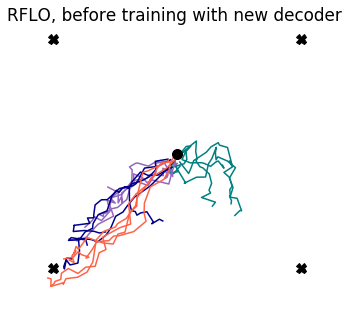

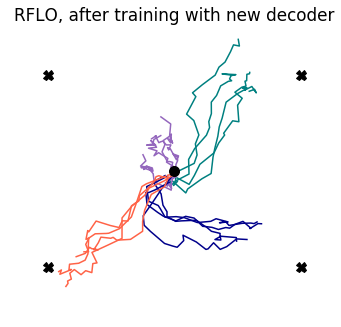

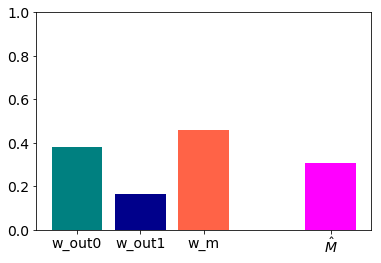

10it [00:00, 97.40it/s]

M norm: 1.38	 M angle: 0.60, 14 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.44
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.40	 w_out1 vs. Mhat angle: 0.34

500it [00:04, 116.49it/s]
1500it [00:16, 90.28it/s]
500it [00:04, 116.69it/s]


AR early fit 0.981, late fit 0.987


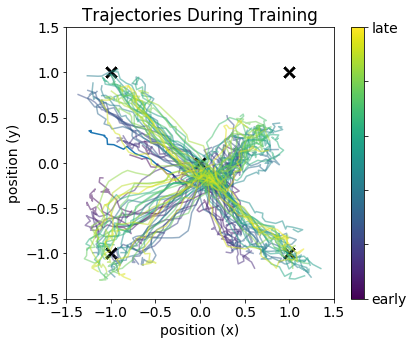

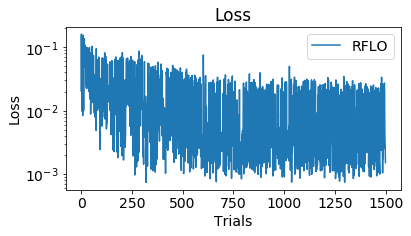

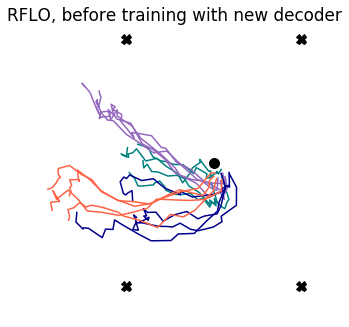

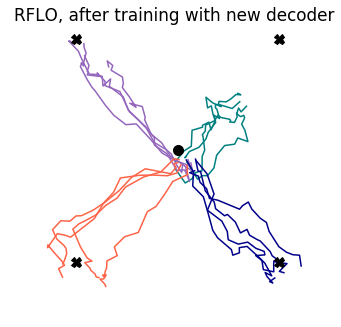

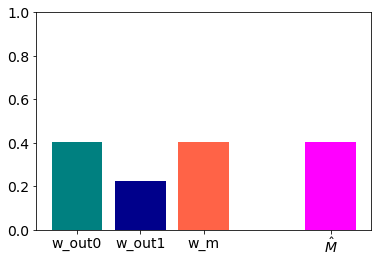

0it [00:00, ?it/s]

M norm: 1.04	 M angle: 0.79, 956 iterations
w_out1 norm: 1.04	 w_out vs. w_out1 angle: 0.79
w_m norm: 1.55	 w_out1 vs. w_m angle: 0.62
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.31	 w_out1 vs. Mhat angle: 0.55

500it [00:04, 111.83it/s]
1500it [00:16, 91.06it/s]
500it [00:04, 117.00it/s]


AR early fit 0.983, late fit 0.985


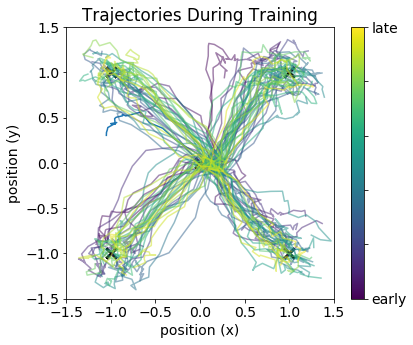

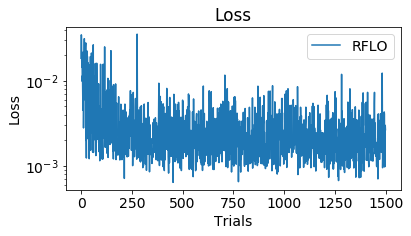

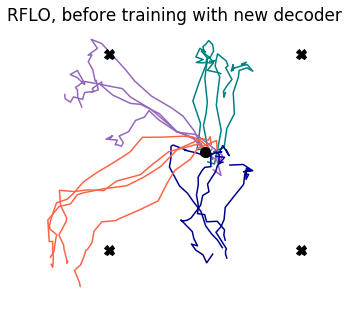

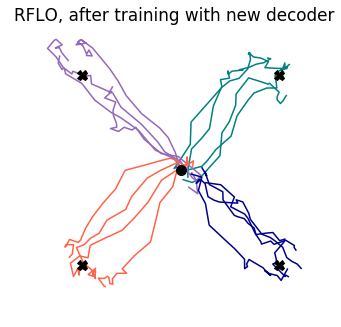

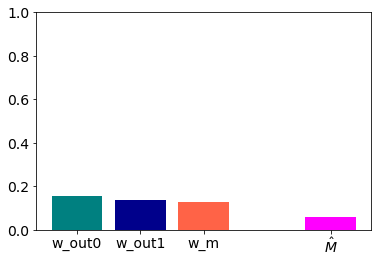

11it [00:00, 104.33it/s]

M norm: 1.75	 M angle: 0.20, 7 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.06	 w_out1 vs. w_m angle: 0.11
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.41	 w_out1 vs. Mhat angle: 0.06

500it [00:04, 116.74it/s]
1500it [00:16, 91.40it/s]
500it [00:04, 116.99it/s]


AR early fit 0.979, late fit 0.992


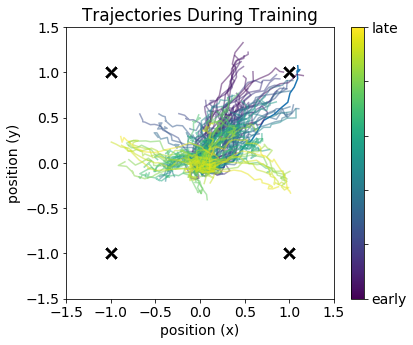

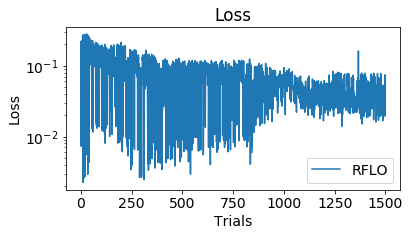

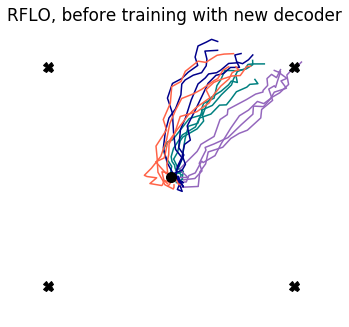

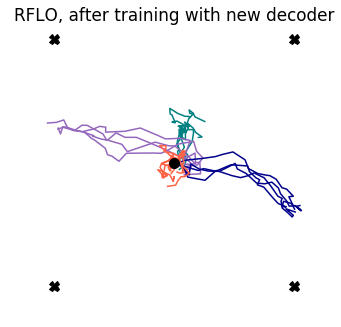

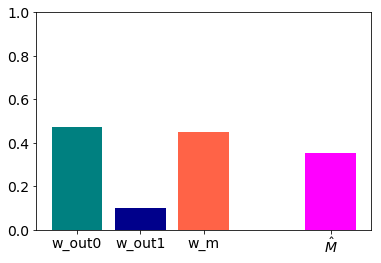

11it [00:00, 104.60it/s]

M norm: 1.62	 M angle: 0.39, 15 iterations
w_out1 norm: 1.62	 w_out vs. w_out1 angle: 0.39
w_m norm: 2.02	 w_out1 vs. w_m angle: 0.24
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.50	 w_out1 vs. Mhat angle: 0.14

500it [00:04, 117.39it/s]
1500it [00:16, 91.13it/s]
500it [00:04, 117.09it/s]


AR early fit 0.979, late fit 0.991


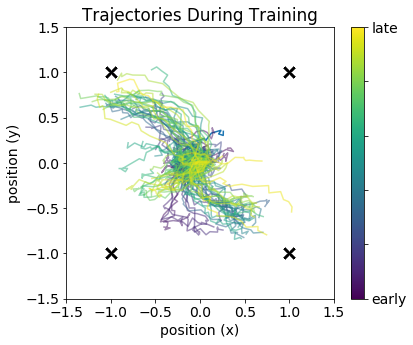

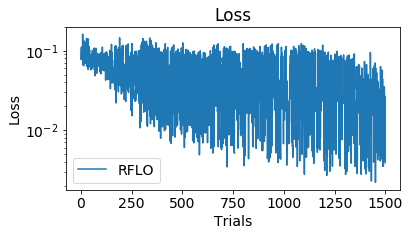

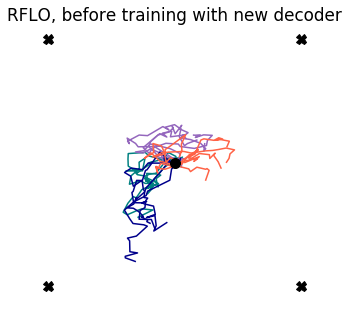

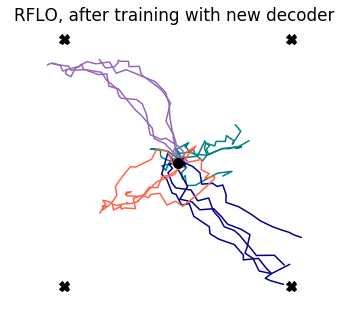

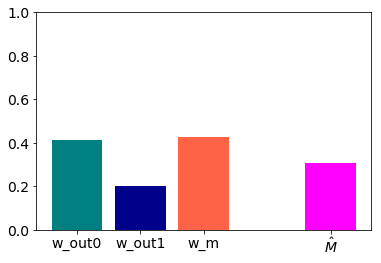

10it [00:00, 98.44it/s]

M norm: 1.37	 M angle: 0.60, 28 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.68	 w_out1 vs. w_m angle: 0.53
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.29	 w_out1 vs. Mhat angle: 0.45

500it [00:04, 116.67it/s]
1500it [00:16, 90.33it/s]
500it [00:04, 110.26it/s]


AR early fit 0.981, late fit 0.987


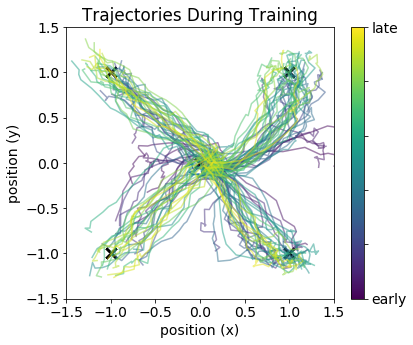

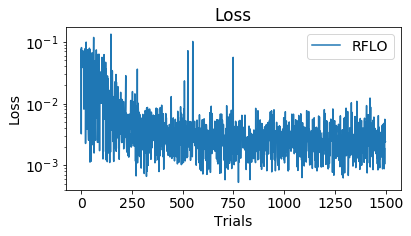

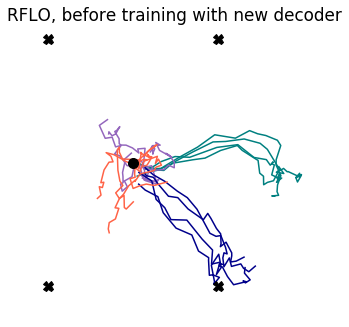

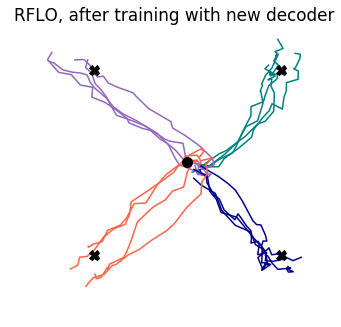

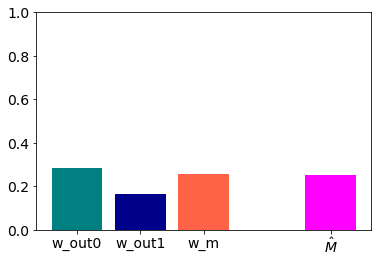

5it [00:00, 47.81it/s]

M norm: 1.00	 M angle: 0.81, 617 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.44	 w_out1 vs. w_m angle: 0.68
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.22	 w_out1 vs. Mhat angle: 0.62

500it [00:05, 99.53it/s] 
1500it [00:16, 89.36it/s]
500it [00:04, 117.82it/s]


AR early fit 0.983, late fit 0.983


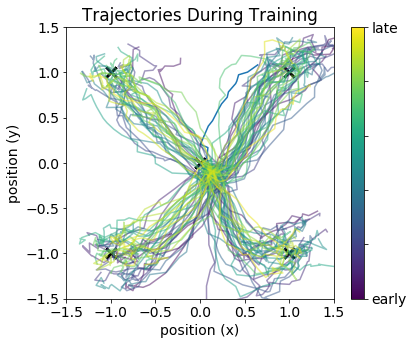

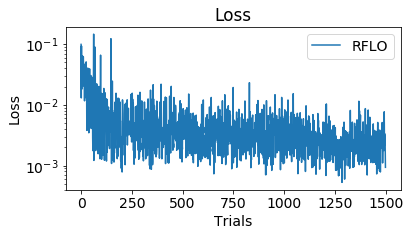

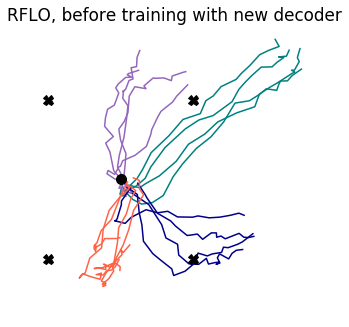

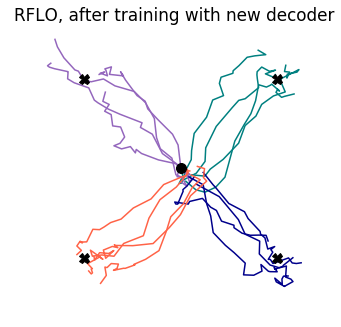

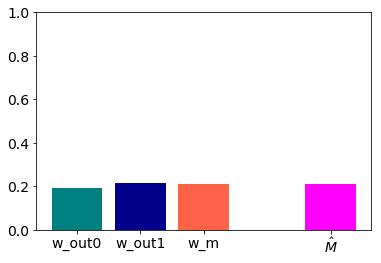

In [64]:


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,eta_fb=0.1,g_fb=2,
               sig_in=0.0,sig_rec=0.2,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

scale=5

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)

w_m = choose_aligned_matrix(net0.w_out.T,n_change=20,overlap=0.8,rng=np.random.RandomState(56),zero=False,tolerance=0.01,loop=1000)

""" set M and Wfb to be equal """
net0.set_weights(w_m = scale*w_m, w_fb = scale*w_m)

rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Apply PCA to static activity, Estimate Mhat """
net0_post = RNN(params)
net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
sim0_post = Simulation(net0_post)
trackvars = TrackVars(net0_post,apply_to=[]) 
sim0_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

# concatenate data
activity = sim0_post.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0_post.session_probes['h'])):
    activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

""" Apply PCA """
pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_

print('C: ',pca.components_.shape)
fig,ax = plt.subplots()
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()


""" Compare with cursor location """
pos = sim0_post.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0_post.session_probes['pos'])):
    pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

Mhat = (D@C).T






""" Average over multiple seeds """
seeds = [0,1,3] #,1,12,54,72,81]
overlaps = [0.2,0.4,0.6,0.8]
n_changes = [80,60,50,15]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(w_out1,Mhat.T)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out1 vs. Mhat angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = net0.w_m.copy()) # still use true w_m

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = net0.w_m.copy()) # still use true w_m




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        rflo = RFLO(net1,apply_to=['w_rec'],online=False)
        sim1_train.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['h','loss','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(), w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out.copy())
        net1_post.set_weights(w_m = net1.w_m.copy())

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='RFLO, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT
        Fpred_w_Mhat = flow_field_predicted(Mhat.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_w_Mhat,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,4],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m',r'$\hat{M}$'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
      
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)



In [70]:
stats_rflo_mhat = stats
stats_rflo_mhat['params']=params

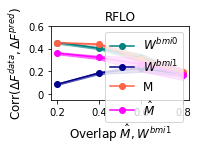

In [68]:
""" Plot scaling of W_fb"""

save = True
paper = True

x = overlaps
n_samples = np.asarray(stats['corr1']).shape[0]
mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
mn4 = np.mean(np.asarray(stats['corr4']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
std4 = np.std(np.asarray(stats['corr4']).T,axis=1)
sem1 = np.std(np.asarray(stats['corr1']).T,axis=1)/np.sqrt(n_samples)
sem2 = np.std(np.asarray(stats['corr2']).T,axis=1)/np.sqrt(n_samples)
sem3 = np.std(np.asarray(stats['corr3']).T,axis=1)/np.sqrt(n_samples)
sem4 = np.std(np.asarray(stats['corr4']).T,axis=1)/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x,mn1,'o-',color='teal',label=r'$W^{bmi0}$')
plt.plot(x,mn2,'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'o-',color='tomato',label='M')
plt.plot(x,mn4,'o-',color='magenta',label=r'$\hat{M}$')
plt.fill_between(x,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')
plt.fill_between(x,mn4-sem4,mn4+sem4,alpha=0.5,color='magenta')



plt.title('RFLO')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Overlap '+r'$\hat{M},W^{bmi1}$')
plt.ylim([-0.05,1.1])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.05,0.6],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'rflo-Mhat.pdf')

4it [00:00, 39.60it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.2
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.2
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2
driving_feedback: True
eta_fb: 0.1
sig_fb: 0.01
feedback_signal: position
velocity_transform: False
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7fd97cc6e360>
M norm: 1.15	 M angle: 0.81, 25 iterations

5000it [01:00, 82.10it/s]
500it [00:04, 108.62it/s]


(20, 50)
n_samples,n_features:  (10000, 50)
C:  (10, 50)


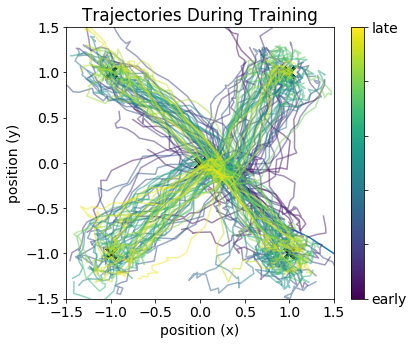

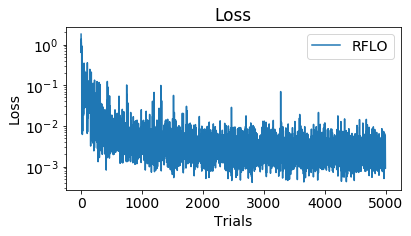

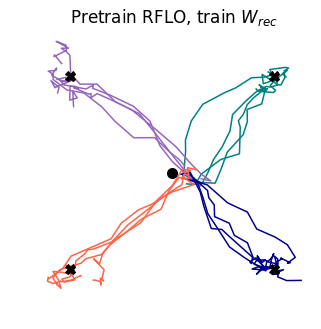

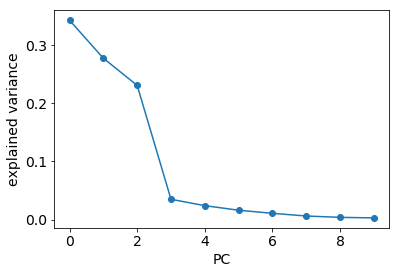

10it [00:00, 99.07it/s]

(20, 2)
(10000, 2)
(2, 10)
M norm: 1.75	 M angle: 0.21, 34 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.21
w_m norm: 2.03	 w_out1 vs. w_m angle: 0.16
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.40	 w_out1 vs. Mhat angle: 0.10

500it [00:04, 106.01it/s]
10000it [02:10, 76.62it/s]
500it [00:04, 110.57it/s]


AR early fit 0.979, late fit 0.981


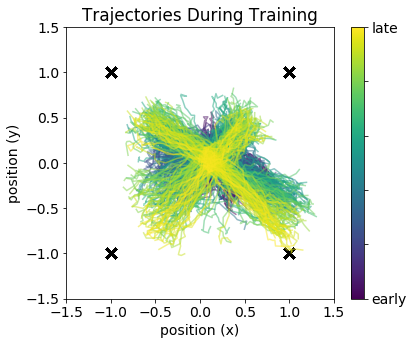

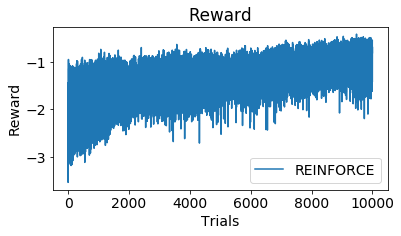

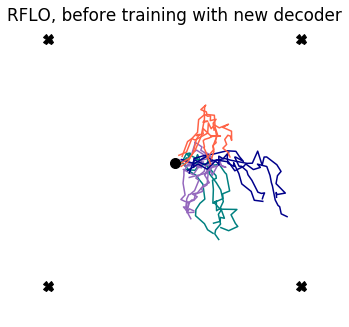

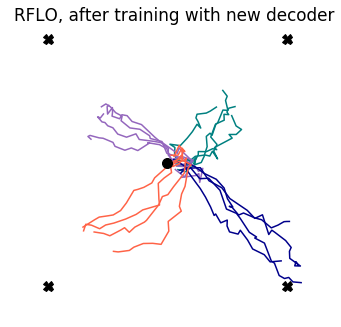

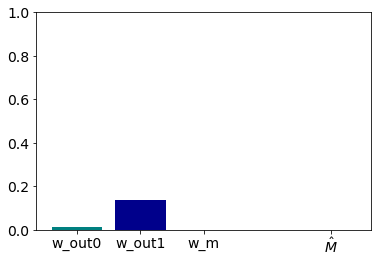

7it [00:00, 66.57it/s]

M norm: 1.60	 M angle: 0.41, 98 iterations
w_out1 norm: 1.60	 w_out vs. w_out1 angle: 0.41
w_m norm: 1.91	 w_out1 vs. w_m angle: 0.33
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.33	 w_out1 vs. Mhat angle: 0.32

500it [00:04, 113.11it/s]
10000it [02:09, 77.07it/s]
500it [00:04, 110.62it/s]


AR early fit 0.980, late fit 0.983


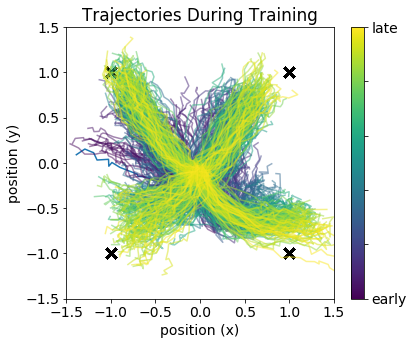

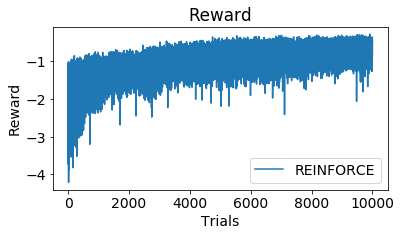

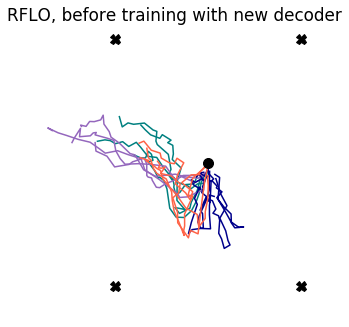

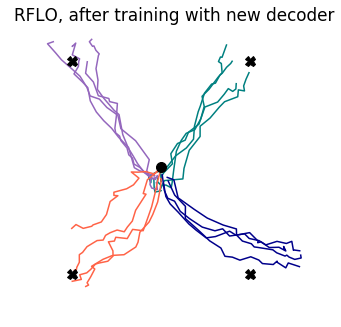

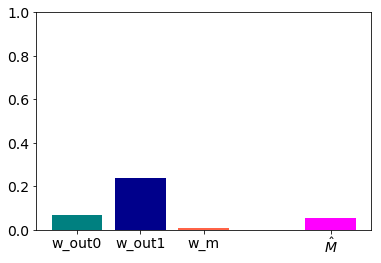

11it [00:00, 103.79it/s]

M norm: 1.37	 M angle: 0.60, 6 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.43
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.27	 w_out1 vs. Mhat angle: 0.44

500it [00:04, 113.31it/s]
10000it [02:04, 80.50it/s]
500it [00:05, 88.84it/s] 


AR early fit 0.980, late fit 0.984


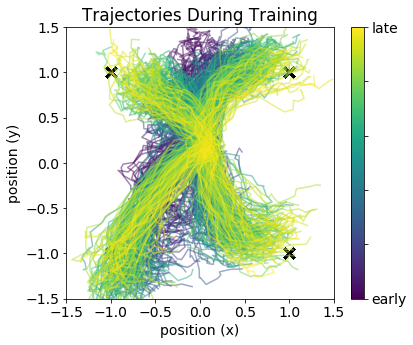

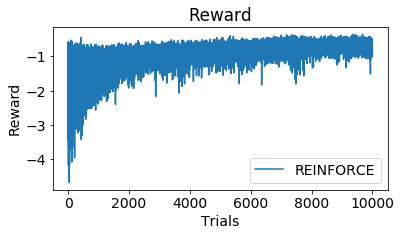

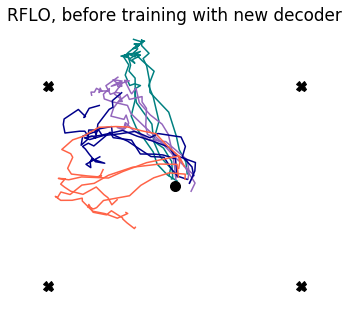

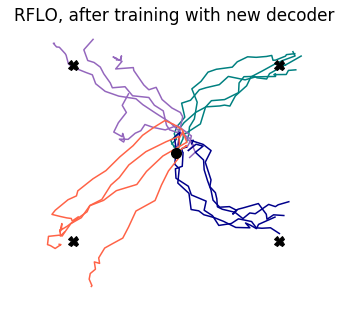

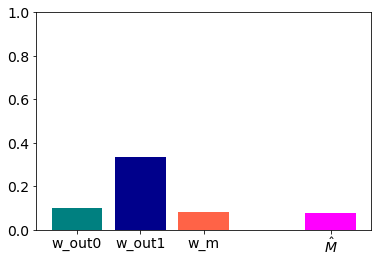

6it [00:00, 52.80it/s]

M norm: 1.00	 M angle: 0.81, 619 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.51	 w_out1 vs. w_m angle: 0.64
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.36	 w_out1 vs. Mhat angle: 0.49

500it [00:04, 101.80it/s]
10000it [02:10, 76.45it/s]
500it [00:04, 113.31it/s]


AR early fit 0.982, late fit 0.983


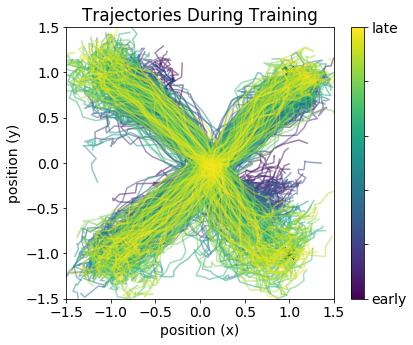

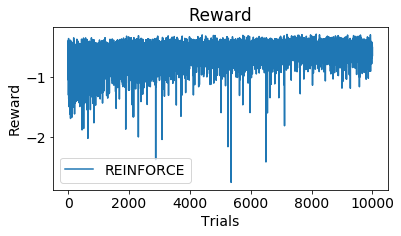

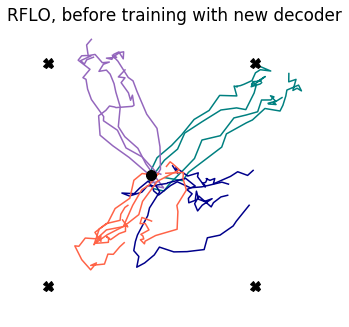

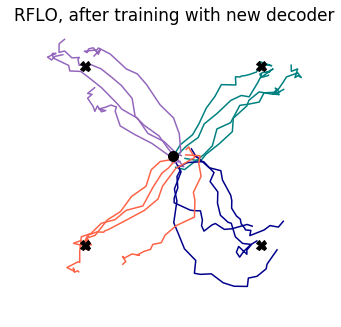

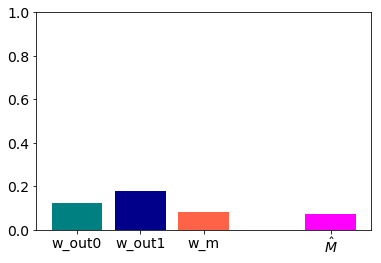

10it [00:00, 94.16it/s]

M norm: 1.75	 M angle: 0.20, 25 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.05	 w_out1 vs. w_m angle: 0.12
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.37	 w_out1 vs. Mhat angle: 0.11

500it [00:04, 112.41it/s]
10000it [02:05, 79.87it/s]
500it [00:04, 110.98it/s]


AR early fit 0.979, late fit 0.982


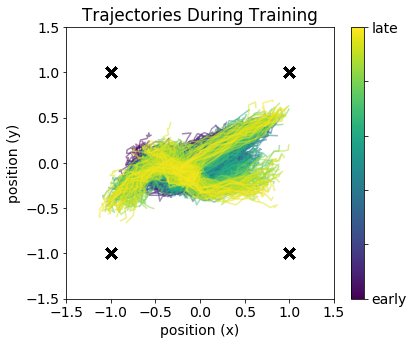

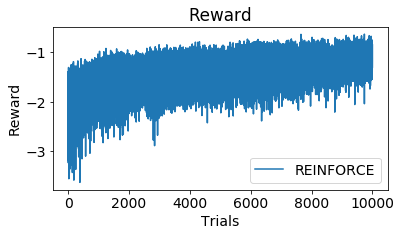

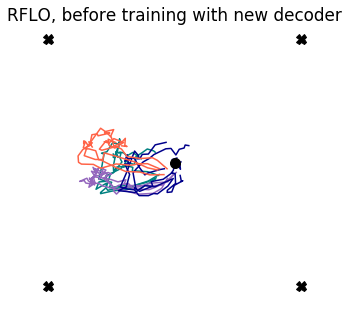

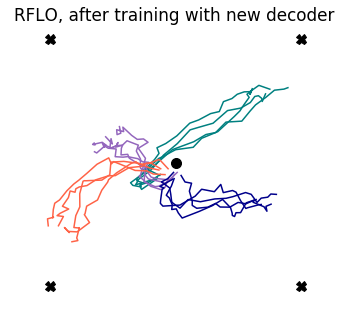

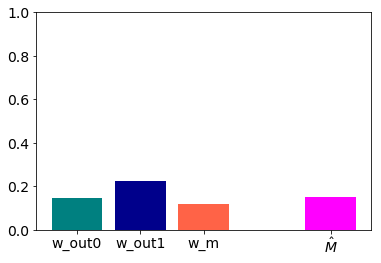

6it [00:00, 56.00it/s]

M norm: 1.61	 M angle: 0.39, 116 iterations
w_out1 norm: 1.61	 w_out vs. w_out1 angle: 0.39
w_m norm: 1.89	 w_out1 vs. w_m angle: 0.34
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.39	 w_out1 vs. Mhat angle: 0.24

500it [00:06, 74.95it/s]
10000it [02:16, 73.53it/s]
500it [00:05, 96.29it/s]


AR early fit 0.980, late fit 0.981


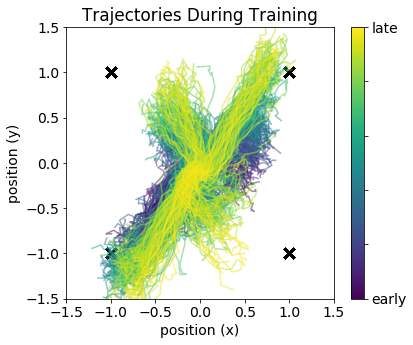

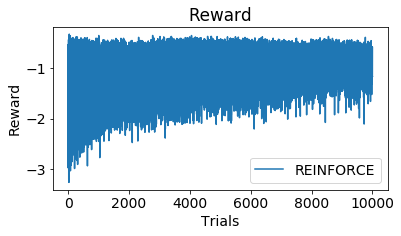

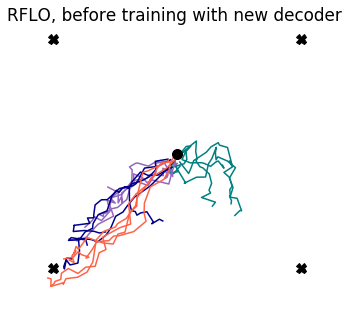

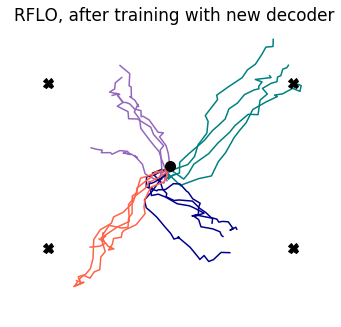

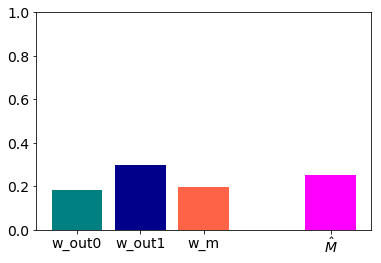

9it [00:00, 77.29it/s]

M norm: 1.38	 M angle: 0.60, 14 iterations
w_out1 norm: 1.38	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.81	 w_out1 vs. w_m angle: 0.44
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.40	 w_out1 vs. Mhat angle: 0.34

500it [00:05, 92.89it/s]
10000it [02:16, 73.32it/s]
500it [00:04, 113.80it/s]


AR early fit 0.981, late fit 0.983


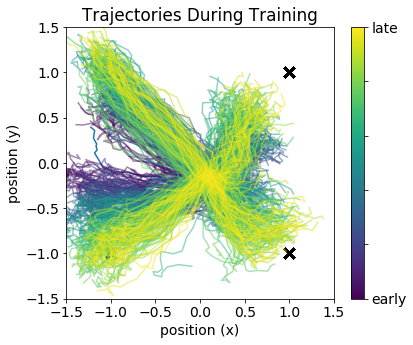

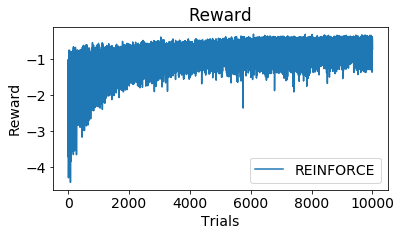

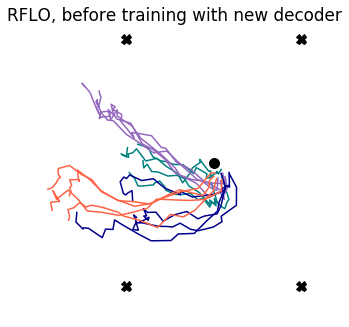

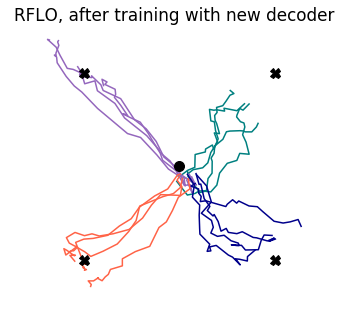

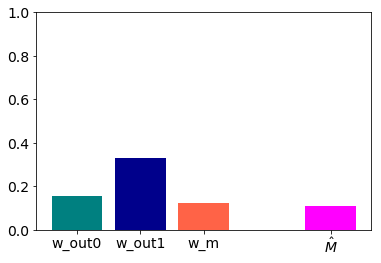

0it [00:00, ?it/s]

M norm: 1.04	 M angle: 0.79, 956 iterations
w_out1 norm: 1.04	 w_out vs. w_out1 angle: 0.79
w_m norm: 1.55	 w_out1 vs. w_m angle: 0.62
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.31	 w_out1 vs. Mhat angle: 0.55

500it [00:04, 104.60it/s]
10000it [02:13, 64.40it/s]
500it [00:05, 96.95it/s]


AR early fit 0.983, late fit 0.984


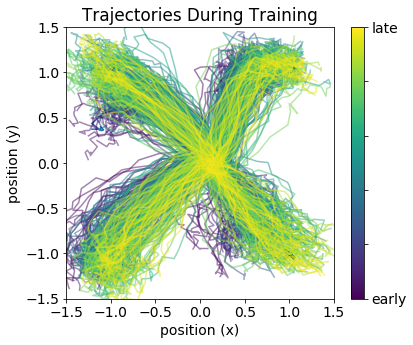

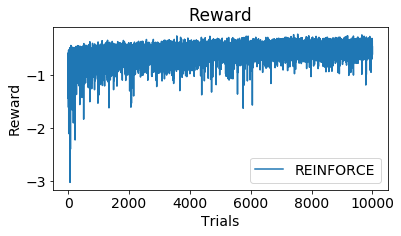

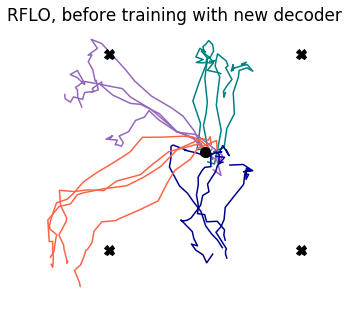

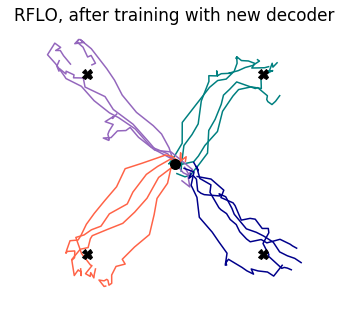

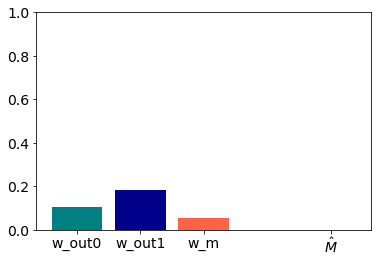

10it [00:00, 99.58it/s]

M norm: 1.75	 M angle: 0.20, 7 iterations
w_out1 norm: 1.75	 w_out vs. w_out1 angle: 0.20
w_m norm: 2.06	 w_out1 vs. w_m angle: 0.11
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.42	 w_out1 vs. Mhat angle: 0.06

500it [00:05, 84.86it/s]
10000it [02:03, 81.28it/s]
500it [00:04, 122.41it/s]


AR early fit 0.979, late fit 0.982


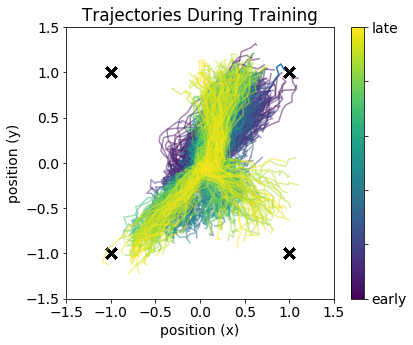

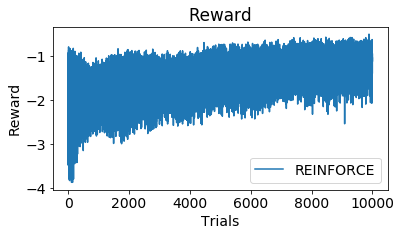

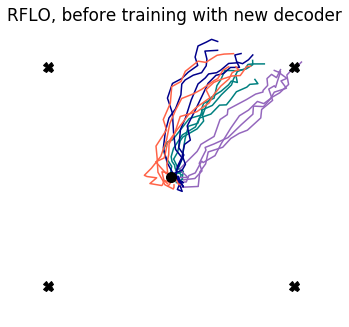

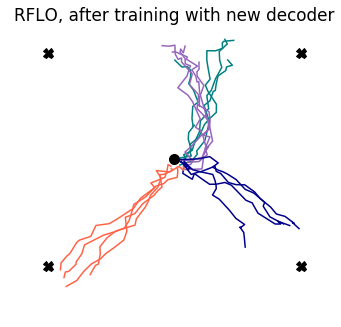

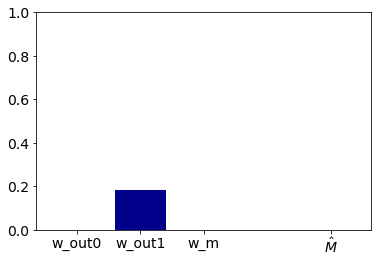

11it [00:00, 105.23it/s]

M norm: 1.62	 M angle: 0.39, 15 iterations
w_out1 norm: 1.62	 w_out vs. w_out1 angle: 0.39
w_m norm: 2.02	 w_out1 vs. w_m angle: 0.24
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.50	 w_out1 vs. Mhat angle: 0.15

500it [00:04, 122.79it/s]
10000it [01:53, 88.38it/s]
500it [00:04, 121.65it/s]


AR early fit 0.979, late fit 0.980


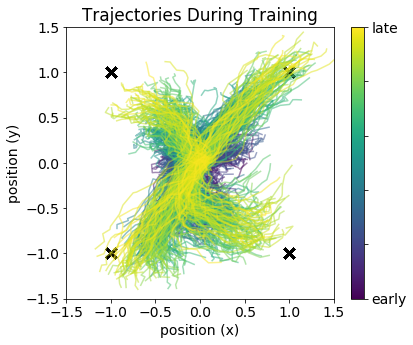

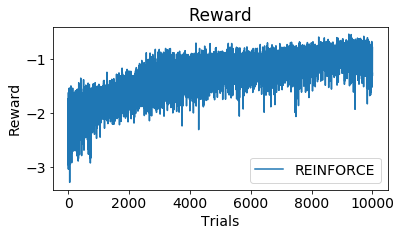

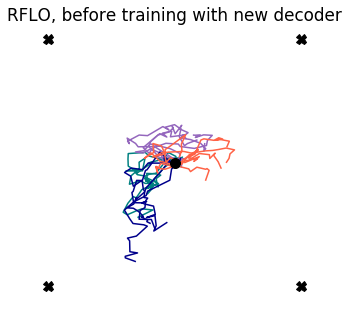

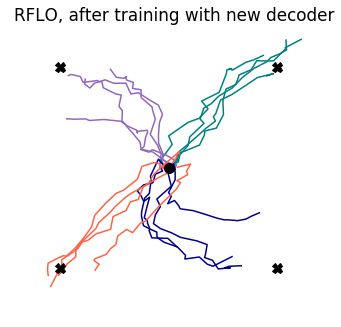

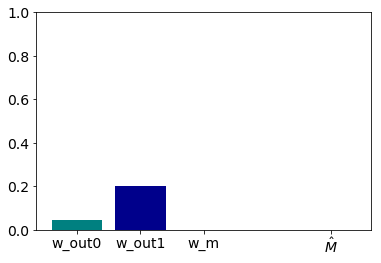

11it [00:00, 104.45it/s]

M norm: 1.37	 M angle: 0.60, 28 iterations
w_out1 norm: 1.37	 w_out vs. w_out1 angle: 0.60
w_m norm: 1.68	 w_out1 vs. w_m angle: 0.53
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.29	 w_out1 vs. Mhat angle: 0.45

500it [00:04, 122.12it/s]
10000it [02:12, 75.32it/s]
500it [00:05, 98.12it/s]


AR early fit 0.981, late fit 0.984


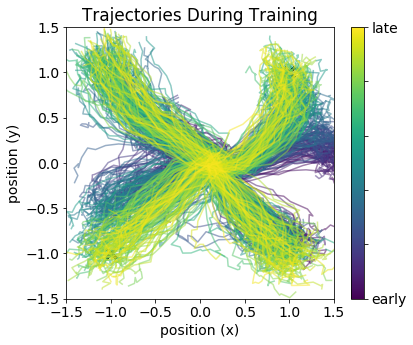

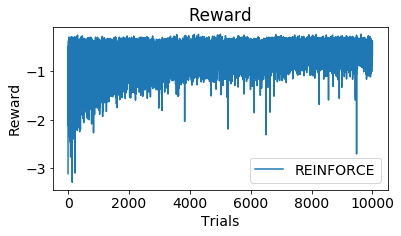

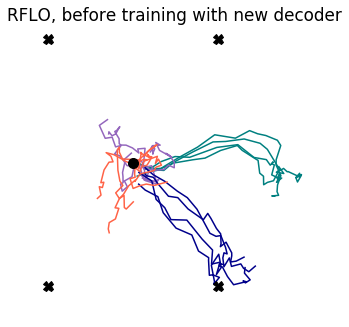

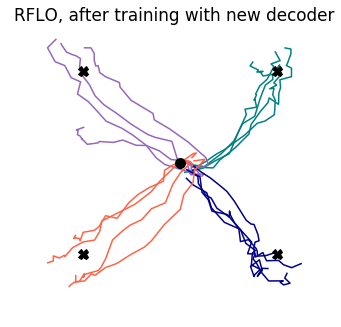

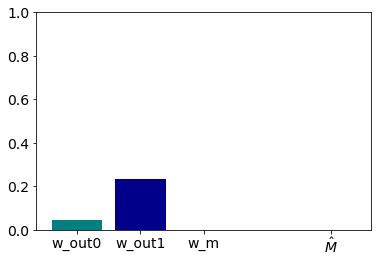

6it [00:00, 55.38it/s]

M norm: 1.00	 M angle: 0.81, 617 iterations
w_out1 norm: 1.00	 w_out vs. w_out1 angle: 0.81
w_m norm: 1.44	 w_out1 vs. w_m angle: 0.68
w_m norm: 1.15	 w_out vs. w_m angle: 0.81
w_out1 norm: 1.22	 w_out1 vs. Mhat angle: 0.62

500it [00:05, 94.21it/s] 
10000it [02:04, 80.45it/s]
500it [00:04, 121.98it/s]


AR early fit 0.983, late fit 0.983


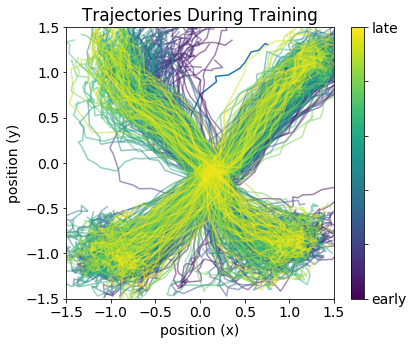

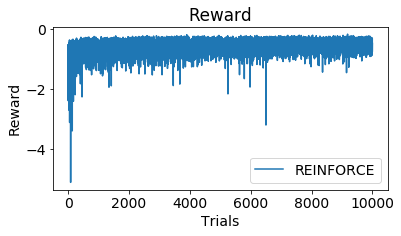

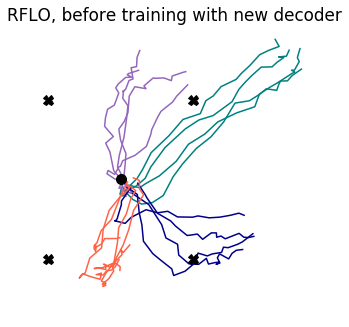

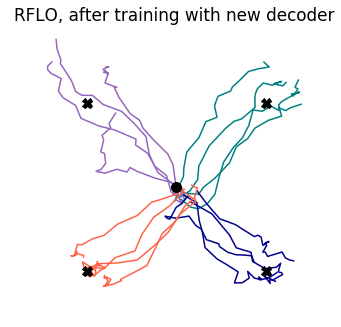

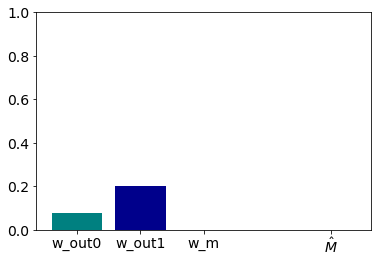

In [73]:


# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.2,eta_out=0.1,eta_fb=0.1,g_fb=2,
               sig_in=0.0,sig_rec=0.2,sig_out=0.01,sig_fb=0.01,
               velocity_transform=False, tau_vel = 0.8, dt_vel = 0.1,
               driving_feedback=True,
               rng=np.random.RandomState(72))
params.print_params()

scale=5

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)

w_m = choose_aligned_matrix(net0.w_out.T,n_change=20,overlap=0.8,rng=np.random.RandomState(56),zero=False,tolerance=0.01,loop=1000)

""" set M and Wfb to be equal """
net0.set_weights(w_m = scale*w_m, w_fb = scale*w_m)

rflo = RFLO(net0,apply_to=['w_rec'],online=False)
sim0.run_session(n_trials=5000, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss','h'], plot=True, plot_freq=20)

fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='Pretrain RFLO, train '+r'$W_{rec}$')






""" Apply PCA to static activity, Estimate Mhat """
net0_post = RNN(params)
net0_post.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(),w_fb = net0.w_fb.copy(),w_m = net0.w_m.copy())
sim0_post = Simulation(net0_post)
trackvars = TrackVars(net0_post,apply_to=[]) 
sim0_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err','pos'], plot=False, plot_freq=10)

# concatenate data
activity = sim0_post.session_probes['h'][0].squeeze()
print(activity.shape)

for i in range(1,len(sim0_post.session_probes['h'])):
    activity = np.vstack((activity,sim0_post.session_probes['h'][i].squeeze()))
    
print('n_samples,n_features: ',activity.shape)

""" Apply PCA """
pca = PCA(n_components=10)
pca.fit(activity)
C = pca.components_

print('C: ',pca.components_.shape)
fig,ax = plt.subplots()
#plt.plot(pca.explained_variance_/np.sum(pca.explained_variance_),'o-') # same dealio
plt.plot(pca.explained_variance_ratio_,'o-')
plt.ylabel('explained variance')
plt.xlabel('PC')
plt.show()


""" Compare with cursor location """
pos = sim0_post.session_probes['pos'][0].squeeze()
print(pos.shape)

for i in range(1,len(sim0_post.session_probes['pos'])):
    pos = np.vstack((pos,sim0_post.session_probes['pos'][i].squeeze()))
print(pos.shape)

lr = LinearRegression(fit_intercept=False)
lr.fit((C @ activity.T).T, pos)
D = lr.coef_

print(D.shape)

Mhat = (D@C).T






""" Average over multiple seeds """
seeds = [0,1,3] #,1,12,54,72,81]
overlaps = [0.2,0.4,0.6,0.8]
n_changes = [80,60,50,15]



stats = {}
stats['corr1'] = []
stats['corr2'] = []
stats['corr3'] = []
stats['corr4'] = []
stats['corrcoef'] = []

for seed in seeds:

    corr1_list = []
    corr2_list = []
    corr3_list = []
    corr4_list = []
    corrcoef_list = []


    for overlap,n_change in zip(overlaps,n_changes):
        
        w_out1 = choose_aligned_matrix(net0.w_out.copy(),n_change=n_change,overlap=overlap,rng=np.random.RandomState(seed),zero=False,tolerance=0.01,loop=1000)

        # confirm overlap between w_out1 and w_out
        norm, angle = return_norm_and_angle(net0.w_out,w_out1)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out vs. w_out1 angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out1 and w_m
        norm, angle = return_norm_and_angle(w_out1,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out1 vs. w_m angle: {:.2f}'.format(angle),end='')

        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(net0.w_out,w_m.T)
        print('\nw_m norm: {:.2f}'.format(norm) + '\t w_out vs. w_m angle: {:.2f}'.format(angle),end='')
        
        # confirm overlap between w_out and w_m
        norm, angle = return_norm_and_angle(w_out1,Mhat.T)
        print('\nw_out1 norm: {:.2f}'.format(norm) + '\t w_out1 vs. Mhat angle: {:.2f}'.format(angle),end='')
        
        
        
        
        net1_pre = RNN(params)
        net1_pre.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1_pre.set_weights(w_out = w_out1)
        net1_pre.set_weights(w_m = net0.w_m.copy()) # still use true w_m

        # unfortunately I need to make a different network to maintain integrity of pre and post simulations for plotting
        net1 = RNN(params)
        net1.set_weights(w_in=net0.w_in.copy(), w_rec=net0.w_rec.copy(), w_fb = net0.w_fb.copy())
        net1.set_weights(w_out = w_out1)
        net1.set_weights(w_m = net0.w_m.copy()) # still use true w_m




        """ Track activity with new decoder, before training """

        sim1_pre = Simulation(net1_pre)
        trackvars = TrackVars(net1_pre,apply_to=[]) 
        sim1_pre.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)
        #fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='RFLO, before training with new decoder')

        """ Train with new decoder """

        sim1_train = Simulation(net1)
        reinforce = REINFORCE(net1,apply_to=['w_rec'],online=False,tau_reward=5)
        sim1_train.run_session(n_trials=10000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['h','reward','err'], plot=True, plot_freq=10)

        """ Track activity with new decoder, after training """
        net1_post = RNN(params)
        net1_post.set_weights(w_in=net1.w_in.copy(), w_rec=net1.w_rec.copy(), w_fb = net1.w_fb.copy())
        net1_post.set_weights(w_out = net1.w_out.copy())
        net1_post.set_weights(w_m = net1.w_m.copy())

        sim1_post = Simulation(net1_post)
        trackvars = TrackVars(net1_post,apply_to=[]) 
        sim1_post.run_session(n_trials=500, tasks=[task1,task2,task3,task4], learn_alg=[trackvars], probe_types=['h','err'], plot=False, plot_freq=10)

        
        fig = plot_trained_trajectories(sim=sim1_pre, tasks=[task1,task2,task3,task4],title='REINFORCE, before training with new decoder')

        fig = plot_trained_trajectories(sim=sim1_post, tasks=[task1,task2,task3,task4],title='REINFORCE, after training with new decoder')
        
        
        """ Calculate F fields """
        F_early, score_early = flow_field_data(sim1_pre.session_probes['h'])
        F_late, score_late = flow_field_data(sim1_post.session_probes['h'])

        print('AR early fit {:.3f}, late fit {:.3f}'.format(score_early,score_late))

        Fdata = F_late - F_early

        # separate train and test data from sim1_train
        n_total = len(sim1_train.session_probes['h'])
        n_train = int(0.5 * n_total)
        idx_train = np.random.RandomState(1975+seed).choice(np.arange(0,n_total),size=n_train,replace=False).astype(int)
        idx_test = np.arange(0,n_total)[~idx_train].astype(int)
        #idx_test=idx_train

        h_train = np.asarray(sim1_train.session_probes['h'])[idx_train,:,:,:]
        err_train = np.asarray(sim1_train.session_probes['err'])[idx_train,:,:,:]

        Fpred_w_out = flow_field_predicted(net0.w_out,err_train,h_train)
        Fpred_w_out1 = flow_field_predicted(w_out1,err_train,h_train)
        Fpred_w_m = flow_field_predicted(net1.w_m.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT
        Fpred_w_Mhat = flow_field_predicted(Mhat.T,err_train,h_train) # NOTE Mhat is USED HERE TO PREDICT

        h_test = np.asarray(sim1_train.session_probes['h'])[idx_test,:,:,:]

        corr1 = calculate_flow_field_correlation(Fpred_w_out,Fdata,h_test) # could also sample sim_test
        corr1_list.append(corr1)

        corr2 = calculate_flow_field_correlation(Fpred_w_out1,Fdata,h_test) # could also sample sim_test
        corr2_list.append(corr2)

        corr3 = calculate_flow_field_correlation(Fpred_w_m,Fdata,h_test) # could also sample sim_test
        corr3_list.append(corr3)
        
        corr4 = calculate_flow_field_correlation(Fpred_w_Mhat,Fdata,h_test) # could also sample sim_test
        corr4_list.append(corr4)
        
        fig,ax = plt.subplots(1,1)
        plt.bar([0,1,2,4],[corr1,corr2,corr3,corr4],tick_label=['w_out0','w_out1','w_m',r'$\hat{M}$'],color=['teal','darkblue','tomato','magenta'])
        plt.ylim([0,1])
        plt.show()
        
        
        
        
        
        
      
        
    # update
    stats['corr1'].append(corr1_list)
    stats['corr2'].append(corr2_list)
    stats['corr3'].append(corr3_list)
    stats['corr4'].append(corr4_list)
    #stats['corrcoef'].append(corrcoef_list)



In [78]:
stats_reinforce_mhat = stats
stats_reinforce_mhat['params'] = params

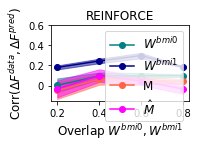

In [81]:
""" Plot scaling of W_fb"""

save = True
paper = True

x = overlaps
n_samples = np.asarray(stats['corr1']).shape[0]
mn1 = np.mean(np.asarray(stats['corr1']).T,axis=1)
mn2 = np.mean(np.asarray(stats['corr2']).T,axis=1)
mn3 = np.mean(np.asarray(stats['corr3']).T,axis=1)
mn4 = np.mean(np.asarray(stats['corr4']).T,axis=1)
std1 = np.std(np.asarray(stats['corr1']).T,axis=1)
std2 = np.std(np.asarray(stats['corr2']).T,axis=1)
std3 = np.std(np.asarray(stats['corr3']).T,axis=1)
std4 = np.std(np.asarray(stats['corr4']).T,axis=1)
sem1 = np.std(np.asarray(stats['corr1']).T,axis=1)/np.sqrt(n_samples)
sem2 = np.std(np.asarray(stats['corr2']).T,axis=1)/np.sqrt(n_samples)
sem3 = np.std(np.asarray(stats['corr3']).T,axis=1)/np.sqrt(n_samples)
sem4 = np.std(np.asarray(stats['corr4']).T,axis=1)/np.sqrt(n_samples)

fig,ax = plt.subplots(1,1)


plt.plot(x,mn1,'o-',color='teal',label=r'$W^{bmi0}$')
plt.plot(x,mn2,'o-',color='darkblue',label=r'$W^{bmi1}$')
plt.plot(x,mn3,'o-',color='tomato',label='M')
plt.plot(x,mn4,'o-',color='magenta',label=r'$\hat{M}$')
plt.fill_between(x,mn1-sem1,mn1+sem1,alpha=0.5,color='teal')
plt.fill_between(x,mn2-sem2,mn2+sem2,alpha=0.5,color='darkblue')
plt.fill_between(x,mn3-sem3,mn3+sem3,alpha=0.5,color='tomato')
plt.fill_between(x,mn4-sem4,mn4+sem4,alpha=0.5,color='magenta')



plt.title('REINFORCE')
plt.ylabel('Corr('+r'$\Delta F^{data},\Delta F^{pred})$')
plt.xlabel('Overlap '+r'$W^{bmi0},W^{bmi1}$')
plt.ylim([-0.15,0.6])
#plt.xlim([-50,1400])
plt.legend()

if paper:
    fig,ax = paper_format(fig=fig,ax=ax,xlabels=None,ylabels=[0,0.2,0.4,0.6,0.8,1],linewidth=2,ylim=[-0.15,0.6],figsize=(2.25,3))

plt.show()

if save:
    fig.savefig(folder+'reinforce-Mhat.pdf')